# Fall 2019 CX4641/CS7641 Homework 3

## Instructor: Dr. Mahdi Roozbahani

## Deadline: Nov 7, Thursday, 11:59 pm

* No unapproved extension of the deadline is allowed. Late submission will lead to 0 credit. 

* Discussion is encouraged, but each student must write his own answers and explicitly mention any collaborators.

* Homework submission ONLY in .ipynb format.  You don't need to submit the image.

## Programming (100pts)

## 1 Principal Component Analysis [20pts]


### Environment Setup

In [1]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import imageio
from sklearn.datasets import load_boston, load_diabetes, load_digits, load_breast_cancer
%matplotlib inline

## Load images data and plot
We load the dataset we will deal with, and show the image

(789, 1052, 3)


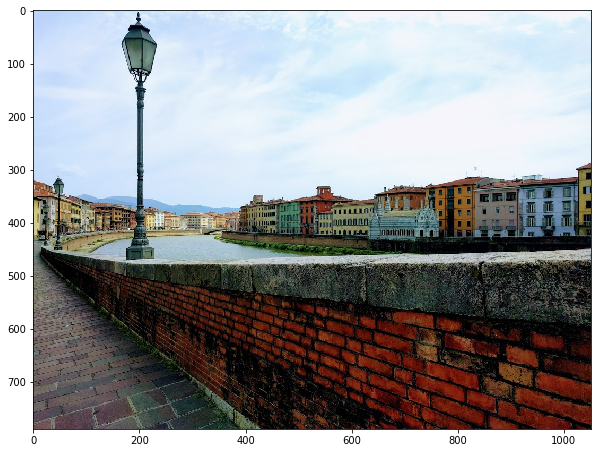

In [26]:
image = plt.imread("hw_3_img.jpg")/255.
print(image.shape)
fig = plt.figure(figsize=(10,10))
plt.imshow(image)

We can transfer the image to grayscale as follows:

(789, 1052)


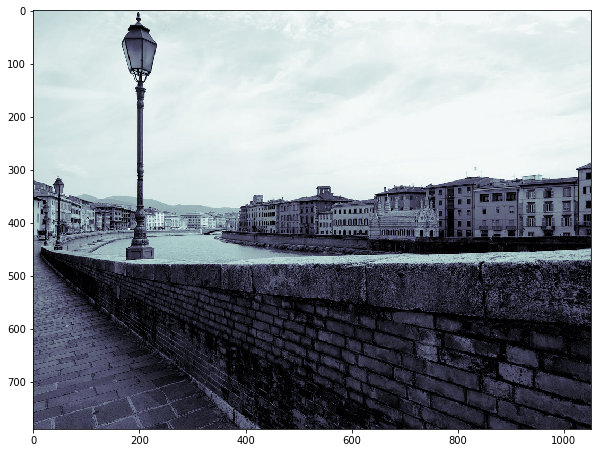

In [27]:
def rgb2gray(rgb):   
    gs = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    print(gs.shape)
    return gs

fig = plt.figure(figsize=(10, 10))
# plot several images
plt.imshow(rgb2gray(image), cmap=plt.cm.bone)

### Image compression

The SVD allows us to compress an image by throwing away the least important information.  The greater the singular values -> the great the variance -> most information from the corresponding singular vector.

SVD each matrix and get rid of the small singular values to compress the image. The loss of inforamtion is negligible as the difference is very difficult to be spotted. 

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)(PCA) follows the same process to elimate the small variance eigenvalues and their vectors.  With PCA, we center the data first by subtracting the mean.

Each singular value tells us how much of the variance of a matrix (e.g. image) is captured in each component.  For example, the variance captured by the first component is $$\frac{\sigma_1}{\sum_{i=1}^n \sigma_i}$$ where $\sigma_i$ is the $i^{th}$ singular value.

You need to finish the following functions to do SVD and then reconstruct the image by components.

In [40]:
def svd(X):
    """
    Do SVD. You could use numpy SVD.
    Your function should be able to handle black and white 
    images (N*D arrays) as well as color images (N*D*3 arrays)

    In the image compression, we assume that each column of the image is a feature. Image is the matrix X.
    
    Args: 
        X: N * D array corresponding to an image (N*D*3 if color image)
    Return:
        U: N*N (*3 for color images) 
        S: min(N, D)*1 (*3 for color images)
        V: D*D (*3 for color images)
    """
    X_tmp = X.copy()
    
    # reshape for color img
    if len(X.shape) == 3:
        X_tmp = np.transpose(X_tmp, (2, 0, 1))
    
    U, S, V = np.linalg.svd(X_tmp, compute_uv=True)
    
    # add dim to S for grayscale image
    if len(S.shape) == 1:
        S = S[:, None]
    
    # reshape for color img
    if len(X.shape) == 3:
        U = np.transpose(U, (1, 2, 0))
        S = S.T
        S = S[:, None, :]
        V = np.transpose(V, (1, 2, 0))
    return U, S, V

def rebuildsvd(U, S, V, k):
    """
    Rebuild SVD by k components.
    Args: 
        U: N*N (*3 for color images) 
        S: min(N, D)*1 (*3 for color images)
        V: D*D (*3 for color images)  
        k: int corresponding to number of components
    Return:
        Xrebuild: N*D array of reconstructed image (N*D*3 if color image)
        
    Hint: numpy.matmul may be helpful for reconstructing color images
    """
    if len(U.shape) == 3:
        U_k = U[:, :k, :]  # NxKx3
        S_k = np.array([np.diag(S[:k, 0, i]) for i in range(3)])
        S_k = S_k.transpose((1, 2, 0))  # KxKxN
        V_k = V[:k, :, :]  # KxDx3
        Xrebuild = np.array([np.dot(np.dot(U_k[:, :, i], S_k[:, :, i]), V_k[:, :, i]) for i in range(3)])
        Xrebuild = Xrebuild.transpose((1, 2, 0))
    else:
        U_k = U[:, :k]
        S_k = np.diag(S[:k].flatten())
        V_k = V[:k]
        Xrebuild = np.dot(np.dot(U_k, S_k), V_k)
    return Xrebuild
    

def compression_ratio(X, k):
    """
    Compute compression of an image: (num stored values in original)/(num stored values in compressed)
    Args: 
        X: N * D array corresponding to an image (N * D * 3 if color image)
        k: int corresponding to number of components
    Return:
        compression_ratio: float of proportion of storage used by compressed image
    """
    total = X.shape[0]*X.shape[1]
    compressed = k*(1+X.shape[0]+X.shape[1])
    return compressed/total

def recovered_variance_proportion(S, k):
    """
    Compute the proportion of the variance in the original matrix recovered by a rank-k approximation
    
    Args:
       S: min(N, D)*1 (*3 for color images) of singular values for the image
       k: int, rank of approximation
    Return:
       recovered_var: int (array of 3 ints for color image) corresponding to proportion of recovered variance
    """
    if len(S.shape) == 3:
        return np.array([S[:k, 0, i].sum()/S[:, 0, i].sum() for i in range(3)])
    return S[:k].sum()/S.sum()

**Now let see the results for image reconstruction.**  
1) Black and White

(789, 1052)


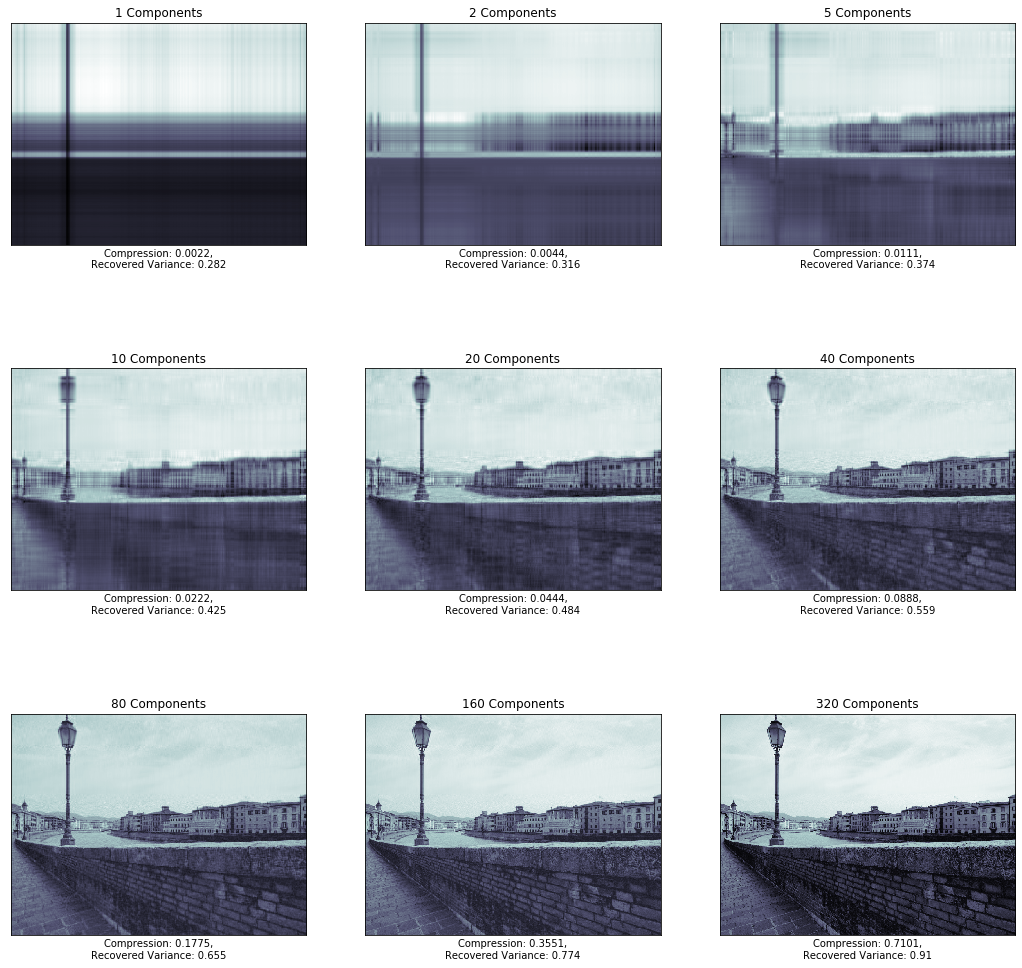

In [5]:
#helper do not need to change

bw_image = rgb2gray(image)
U, S, V = svd(bw_image)
component_num = [1,2,5,10,20,40,80,160,320]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    c = np.around(compression_ratio(image, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild, cmap=plt.cm.bone)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {c},\nRecovered Variance: {r}")
    i = i+1

2) Color

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


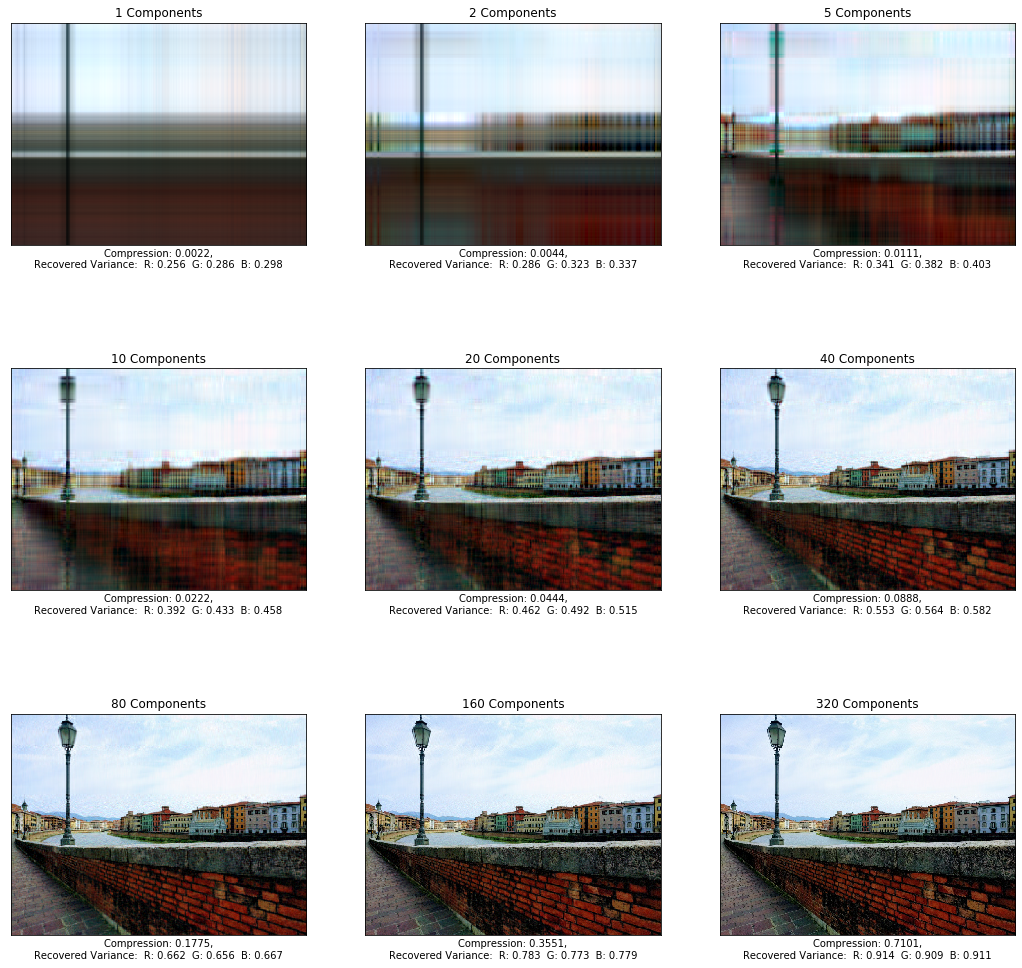

In [6]:
#helper do not need to change

U, S, V = svd(image)
component_num = [1,2,5,10,20,40,80,160,320]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = rebuildsvd(U, S, V, k)
    c = np.around(compression_ratio(image, k), 4)
    r = np.around(recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {np.around(c,4)},\nRecovered Variance:  R: {r[0]}  G: {r[1]}  B: {r[2]}")
    i = i+1

## 2 Polynomial Regression with Regualrization [35pts + 20pts]

#### 2.1 Helper functions [10pts]
1) RMSE [5pts] 

In [29]:
def rmse(pred, label): 
    '''
    This is the root mean square error.
    Args:
        pred: numpy array of length N * 1, the prediction of labels
        label: numpy array of length N * 1, the ground truth of labels
    Return:
        a float value
    '''
    raise NotImplementedError

# Hint: get the sqaure root of theta hat in slide 14 (https://mahdi-roozbahani.github.io/cse4240-spring2019.github.io/course/14-linear-regression.pdf)
prediction = np.array([1, 2, 3]) 
label = np.array([1.5, 2.5, 3.5])
print('rmse =',rmse(prediction, label))

rmse = 0.5


Do you know whether this RMSE is good or not? If you don't know, we could normalize our labels between 0 and 1. After normalization, what does it mean when RMSE = 1? 

**Hint**: think of the way that you can enforce your RMSE = 1. Note that you can not change the actual labels to make RMSE = 1.

2) Construct polynomial features [5pts]

In [30]:
def construct_polynomial_feats(x, degree):
    """
    Args:
        x: numpy array of length N, the 1-D observations
        degree: the max polynomial degree
    Return:
        feat: numpy array of shape Nx(degree+1), remember to include 
        the bias term. feat is in the format of:
        [[1.0, x1, x1^2, x1^3, ....,],
         [1.0, x2, x2^2, x2^3, ....,],
         ......
        ]
    """
    raise NotImplementedError
# Here there are two data points. One data point is 0.5 and other one is 0.2. 
# We try to represent these two data points in higher dimensions.

x = np.array([0.5, 0.2]) 
x_feat = construct_polynomial_feats(x, 4)
print(x_feat)

[[1.     0.5    0.25   0.125  0.0625]
 [1.     0.2    0.04   0.008  0.0016]]


In [31]:
#helper do not need to change
def plot_curve(x, y, curve_type='.', color='b', lw=2):
    plt.plot(x, y, curve_type, color=color, linewidth=lw)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)

#### 2.2 Linear Regression [10pts + 10pts]

We have three methods to fit linear gression model: 1) close form; 2)Gradient descent (GD); 3) Stochastic gradient descent (SGD). For undergraduate students, you are required to implement 1), and the other two are bonus parts; for graduate students, you are required to implement all of them. Each method has 5 points.

After fitting the model, we need to implement the prediction function. [5pts]

In [34]:
class LinearReg(object):
    @staticmethod 
    # static method means that you can use this method or function for any other classes, it is not specific to LinearReg
    def fit_closed(xtrain, ytrain):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytarin: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
    raise NotImplementedError
        
    @staticmethod
    def fit_GD(xtrain, ytrain, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
    raise NotImplementedError

    @staticmethod
    def fit_SGD(xtrain, ytrain, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
    raise NotImplementedError

    @staticmethod
    def predict(xtest, weight):
        """
        Args:
            xtest: NxD numpy array, where N is number 
                   of instances and D is the dimensionality of each 
                   instance
            weight: Dx1 numpy array, the weights of linear regression model
        Return:
            prediction: Nx1 numpy array, the predicted labels
        """
    raise NotImplementedError
        
# Hint: in the fit function, use close form solution of the linear regression to get weights. 
# For inverse, you can use numpy linear algebra function  
# For the predict, you need to use linear combination of data points and their weights (y = w0*1+w1*X1+...)

Let's first construct a dataset for polynomial regression.

In this case, we construct the polynomial features up to degree 5, where the groundtruth function is just a linear function (i.e., only require polynomial features up to degree 1).

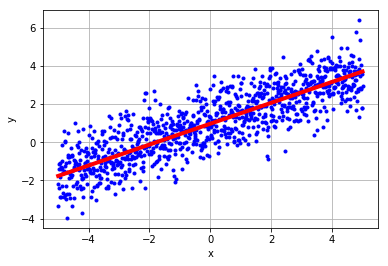

In [35]:
#helper, do not need to change

POLY_DEGREE = 5
NUM_OBS = 1000

rng = np.random.RandomState(seed=4)

true_weight = rng.rand(POLY_DEGREE + 1, 1)
true_weight[2:, :] = 0
x_all = np.linspace(-5, 5, NUM_OBS)
x_all_feat = construct_polynomial_feats(x_all, POLY_DEGREE)
y_all = np.dot(x_all_feat, true_weight) + rng.randn(x_all_feat.shape[0], 1) # in the second term, we add noise to data
# Note that here we try to produce y_all as our training data
plot_curve(x_all, y_all) # Data with noise that we are going to predict
plot_curve(x_all, np.dot(x_all_feat, true_weight), curve_type='-', color='r', lw=4) # the groundtruth information

indices = rng.permutation(NUM_OBS)

In the figure above, the red curve is the true fuction we want to learn, while the blue dots are the noisy observations. The observations are generated by $Y = XW + \sigma$, where $\sigma \sim \mathcal{N}(0, 1)$ are i.i.d. generated noise. 

Now let's split the data into two parts, namely the training set and test set. The red dots are for training, while the blue dots are for testing.

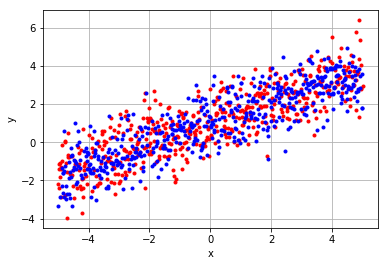

In [36]:
#helper, do not need to change

train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]

plot_curve(x_all[train_indices], y_all[train_indices], color='r')
plot_curve(x_all[test_indices], y_all[test_indices], color='b')

Now let's first train using the entire training set, and see how we performs on the test set and how the learned function look like.

In [37]:
#helper, do not need to change

weight = LinearReg.fit_closed(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 0.9222


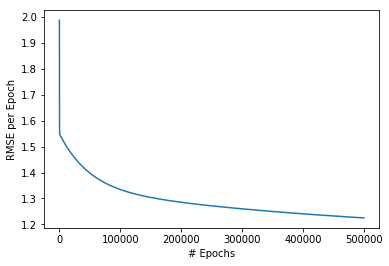

test rmse: 1.1695


In [39]:
weight = LinearReg.fit_GD(x_all_feat[train_indices], y_all[train_indices], epochs=500000, learning_rate=1e-7)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

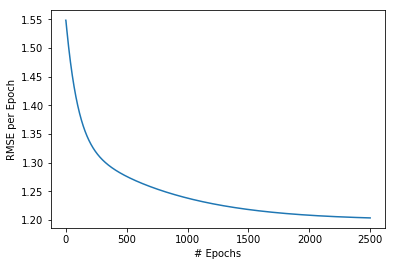

test rmse: 1.1695


In [38]:
weight = LinearReg.fit_SGD(x_all_feat[train_indices], y_all[train_indices], epochs=2500, learning_rate=1e-7)
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

And what if we just use the first 10 observations to train? 

In [45]:
sub_train = train_indices[:10]
weight = LinearReg.fit_closed(x_all_feat[sub_train], y_all[sub_train])
y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 2.1910


Did you see a worse performance? Let's take a closer look at what we have learned.

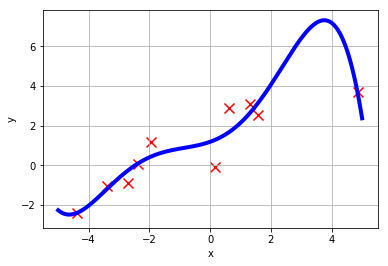

In [46]:
#helper, do not need to change

y_pred = LinearReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred, curve_type='-', color='b', lw=4)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = LinearReg.predict(x_all_feat[test_indices], weight)

#### 2.3 Ridge Regression [5pts + 10pts]

Now let's try ridge regression. Similarly, undergraduate students need to implement the close form, and graduate students need to implement all the three methods. We will call the prediction function from linear regression part.

In [54]:
class RidgeReg(LinearReg):

    @staticmethod
    def fit_closed(xtrain, ytrain, c_lambda):
        raise NotImplementedError
    
    @staticmethod
    def fit_GD(xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        raise NotImplementedError
    
    @staticmethod
    def fit_SGD(xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001):
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        raise NotImplementedError

Again, let's see what we have learned. You only need to run the cell corresponding to your specific implementation.

test rmse: 1.2115


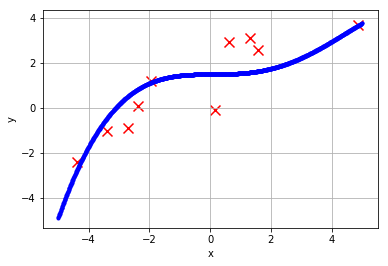

In [55]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_closed(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 1.6672


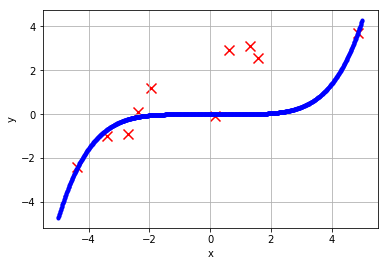

In [50]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_SGD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 1.6446


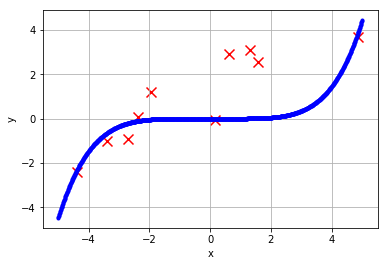

In [51]:
sub_train = train_indices[:10]
weight = RidgeReg.fit_GD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-7)

y_pred = RidgeReg.predict(x_all_feat, weight)
plot_curve(x_all, y_pred)
plt.scatter(x_all[sub_train], y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

#### 2.4 Cross Validation [10pts]
Let's use Cross Validation to find the best value for c_lambda. 

In [58]:
# We provided 6 possible values for lambda, and you will use them in cross validation.
# For cross validation, use 10-fold method and only use it for your training data (you already have the train_indices to get training data).
# For the training data, split them in 10 folds which means that use 10 percent of training data for test and 90 percent for training.
# At the end for each lambda, you have caluclated 10 rmse and get the mean value of that.
# That's it. Pick up the lambda with the lowest mean value of rmse. 
# Hint: np.concatenate is your friend.

def cross_validation(X, y, kfold, c_lambda):
    raise NotImplementedError

best_lambda = None
best_error = None
kfold = 10
lambda_list = [0, 0.1, 1, 5, 10, 100, 1000]
for lm in lambda_list:
    err = cross_validation(x_all_feat[train_indices], y_all[train_indices], kfold, lm)
    print('lambda: %.2f' % lm, 'error: %.6f'% err)
    if best_error is None or err < best_error:
        best_error = err
        best_lambda = lm

print('best_lambda: %.2f' % best_lambda)
weight = RidgeReg.fit_closed(x_all_feat[train_indices], y_all[train_indices], c_lambda=10)
y_test_pred = RidgeReg.predict(x_all_feat[test_indices], weight)
test_rmse = rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

lambda: 0.00 error: 0.999078
lambda: 0.10 error: 0.999076
lambda: 1.00 error: 0.999057
lambda: 5.00 error: 0.998997
lambda: 10.00 error: 0.998973
lambda: 100.00 error: 1.003054
lambda: 1000.00 error: 1.029322
best_lambda: 10.00
test rmse: 0.9227


## 3 PCA analysis [25 pts]

In this problem, we will investigate how PCA can be used to improve features for regression and classification tasks and how the data itself affects the behavior of PCA.  

**Intrinsic Dimensionality [15pts]**  
Assume a dataset is composed of N datapoints, each of which has D features with D < N.  The *dimension* of our data would be $D$. It is possible, however, that many of these dimensions contain redundant information.  The *intrinsic dimensionality* is the number of dimensions we need to reconstruct our data with high fidelity.  For our purposes, we will define the intrinsic dimension as the number of principal components needed to reconstruct 99% of the variation within our data.  

We define a set of features as linearly independent if we cannot construct one out of a linear combination of the others. The number of linearly independent features is the number of nonzero principal components (where we define 0 is anything less than $10^{-11}$ due to floating point error). Zero principal components mean that we can not find any weights to linearly combine features in order to create an indenpendent feature. Thus, our algorithm will assign 0 to these weights.

In [41]:
def pca(X):
    """
    Decompose dataset into principal components. 
    You may use your SVD function from the previous part in your implementation.
    
    Args: 
        X: N*D array corresponding to a dataset
    Return:
        U: N*N 
        S: min(N, D)*1 
        V: D*D
    """
    return svd(X)
    
def intrinsic_dimension(S, recovered_variance=.99):
    """
    Find the number of principal components necessary to recover given proportion of variance
    
    Args: 
        S: 1-d array corresponding to the singular values of a dataset
        
        recovered_varaiance: float in [0,1].  Minimum amount of variance 
            to recover from given principal components
    Return:
        dim: int, the number of principal components necessary to recover 
            the given proportion of the variance
    """
    VAR = (S**2).cumsum()
    return (VAR/VAR[-1] > recovered_variance).argmax() + 1
    
def num_linearly_ind_features(S, eps=1e-11):
    """
    Find the number of linearly independent featues in dataset
    
    Args: 
        S: 1-d array corresponding to the singular values of a dataset
    Return:
        dim: int, the number of linearly independent dimensions in our data
    """
    return (S > eps).sum()

Use your above functions to find the intrinsic dimensionality and number of linearly independent components in the following datasets:
* Digits (handwritten digits)
* Breast Cancer
* Boston Housing
* Diabetes

In [42]:
#helper, don't need to change
digits = load_digits()
cancer = load_breast_cancer()
boston = load_boston()
diabetes = load_diabetes()

In [43]:
print("Total Features")
print("\tDigits", digits.data.shape[1])
print("\tBreast Cancer", cancer.data.shape[1])
print('\tBoston', boston.data.shape[1])
print('\tDiabetes', diabetes.data.shape[1])

Total Features
	Digits 64
	Breast Cancer 30
	Boston 13
	Diabetes 10


In [44]:
print("Linearly Independent Features:")
print("\tDigits", num_linearly_ind_features(pca(digits.data)[1]))
print("\tBreast Cancer", num_linearly_ind_features(pca(cancer.data)[1]))
print("\tBoston", num_linearly_ind_features(pca(boston.data)[1]))
print("\tDiabetes", num_linearly_ind_features(pca(diabetes.data)[1]))

Linearly Independent Features:
	Digits 61
	Breast Cancer 30
	Boston 13
	Diabetes 10


In [45]:
print("Intrinsic Dimensionality:")
print("\tDigits", intrinsic_dimension(pca(digits.data)[1]))
print("\tBreast Cancer", intrinsic_dimension(pca(cancer.data)[1]))
print("\tBoston", intrinsic_dimension(pca(boston.data)[1]))
print("\tDiabetes", intrinsic_dimension(pca(diabetes.data)[1]))

Intrinsic Dimensionality:
	Digits 33
	Breast Cancer 1
	Boston 2
	Diabetes 8


**Feature Scaling [10pts]**

Principal component analysis is not agnostic to the scale of your features.  Measuring a feature with different units can change your principal components.

For this problem, randomly choose one of your a column in each of the above datasets and multiply it by 1000.  For each of the datasets, answer the following:
1. How does this change the distribution of variance among the first 10 components?  
2. How does this change the first principal component of the data?
3. How does this affect the number of linearly independent components and intrinsic dimensionality?  Why?

It may be helpful to plot the variance captured by each component in a scree plot (see function below) and to make a bar plot of the absolute value of each feature in the first principal component.  

In [46]:
def randomly_perturb_data(data, multiplier=1000):
    """
    Multiply a random column in data by multiplier
    
    Inputs:
        data: N*D numpy array of features
        multiplier: multiplier by which to perturb a random column in data
        
    Returns:
        perturbed_data: Data with random column multiplied by multiplier
    """
    tmp = data.copy()
    idx = np.random.randint(tmp.shape[1])
    tmp[:, idx] = tmp[:, idx]*multiplier
    return tmp, idx
    
def scree_plot(H, PS, n_components=10, title=None, labels=['base', 'perturbed']):
    """
    Plot proportion of variance contained in each individual component
    """
    raise NotImplementedError
    
def plot_component_vector(V):
    raise NotImplementedError


Linearly Independent Features: digits
	Base: 61
	Perturbed: 64

Linearly Independent Features: cancer
	Base: 30
	Perturbed: 30

Linearly Independent Features: boston
	Base: 13
	Perturbed: 13

Linearly Independent Features: diabetes
	Base: 10
	Perturbed: 10


<Figure size 432x288 with 0 Axes>

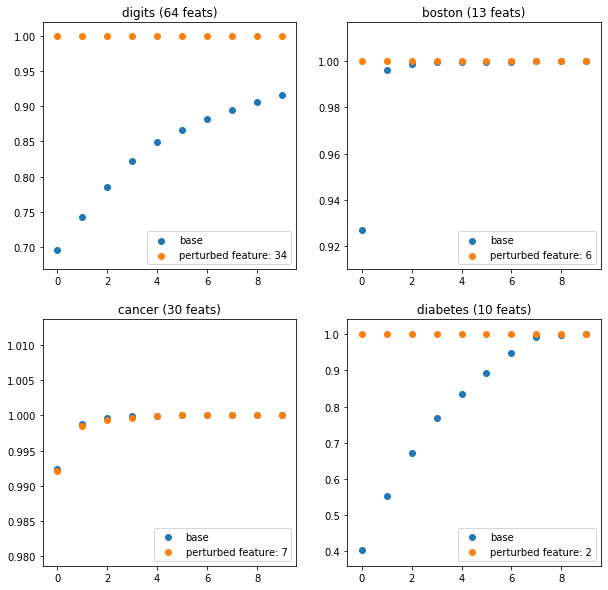

In [69]:
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
titles = [f'digits ({digits.data.shape[1]} feats)', f'cancer ({cancer.data.shape[1]} feats)',
          f'boston ({boston.data.shape[1]} feats)', f'diabetes ({diabetes.data.shape[1]} feats)']
lif_titles = ['digits', 'cancer', 'boston', 'diabetes']
for i, dataset in enumerate([digits, cancer, boston, diabetes]):
    S = pca(dataset.data)[1]
    S = (S**2).cumsum()
    S = S/S[-1]
    
    pdata, pidx = randomly_perturb_data(dataset.data)
    PS = pca(pdata)[1]
    PS = (PS**2).cumsum()
    PS = PS/PS[-1]
    
    print(f'\nLinearly Independent Features: {lif_titles[i]}')
    print(f'\tBase: {num_linearly_ind_features(pca(dataset.data)[1])}')
    print(f'\tPerturbed: {num_linearly_ind_features(pca(pdata)[1])}')
    
    if i < 2:
        ax = axes[i, 0]
    elif i == 2:
        ax = axes[0, 1]
    else:
        ax = axes[1, 1]
    
    ax.scatter(range(10), S[:10], label='base')
    ax.scatter(range(10), PS[:10], label=f'perturbed feature: {pidx}')
    ax.set_title(f'{titles[i]}')
    ax.legend(loc='lower right')

plt.show()


Please write your analysis here: 

With high likelihood, the distribution of principal components for each dataset was heavily skewed to the first principal component (100% of variation described by first component). That being said, the datasets which were already heavily skewed to a small subset of components, namely the boston and cancer datasets, so a more muted impact on distribution given their already heavy concentration. When I repeatedly ran the charts there were some instances where the distribution for cancer was actually lower, which is attributable to the random feature selection and the fact that the first principal component already describes the dataset fully. Although the intrinsic dimensionality for Boston and cancer was somewhat muted, the first principal component's composition most likely changed significantly as a result of the scale transformation. As a result, Boston and cancer appear to be fully described by a similar number of principal components both in the base and the perturbed case, but the mix of the components has been impacted by the scale transformation. As shown in the above analysis, the number of linearly independent features was not impacted by the transformation, which makes sense because the feature composition was magnified, but the shape was not altered so the same linear composition properties should hold.

## 4 Comparison of PCA and LDA [20pts]

We will now look at the results obtained using PCA and compare it to those obtained using **Linear Discriminant Analysis** (LDA). PCA is an unsupervised dimensionality reduction method, whereas LDA is used to find a linear decision boundary for multi-class classification problems. It achieves this by projecting the data onto a lower dimensional subspace to maximize class separability. Due to this, it can also be used for dimensionality reduction. For more details about LDA, refer to section 4.3 of the book Elements of Statistical Learning (https://web.stanford.edu/~hastie/Papers/ESLII.pdf).

For this question, you will be allowed to use the PCA and LDA functions from the **scikit-learn library**. You will be working with the wine dataset. Your goal is to use PCA and LDA to project the data into a two-dimensional subspace and visualize your results using a scatter plot. You should also output the explained variance ratio of the two components that you find using PCA.

In [2]:
# helper function, do not need to change
def load_wine_data():
    from sklearn.datasets import load_wine
    wine = load_wine()
    X, y = wine.data, wine.target
    return X, y #X, y: Feature data and targets of wine dataset

# X shape: (178, 13); y shape (178,)
X, y = load_wine_data()

In [15]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (178, 13)
y shape: (178,)


In [8]:
def PCA(X, y):
    '''
    Use this function to obtain two PCA components which are later used for plotting
    Returns:
        wine_pca: The PCA components
        explained_variance_ratio: Explained variance ratio of the two PCA components 
        (Hint:use sklearn function)
    '''
    from sklearn.decomposition import PCA as SKL_PCA
    model = SKL_PCA(n_components=2).fit(X)
    return model.transform(X), model.explained_variance_ratio_
    
wine_pca, explained_variance_ratio = PCA(X, y)
print('Explained variance ratio of the first two components: %s'
      % str(explained_variance_ratio))

Explained variance ratio of the first two components: [0.99809123 0.00173592]


In [9]:
def LDA(X, y):
    ''' 
    Use this function to obtain 2 (two) LDA components which are later used for plotting
    Returns:
        wine_lda: The LDA components
    '''
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as SKL_LDA
    model = SKL_LDA(n_components=2).fit(X, y)
    return model.transform(X)
    
wine_lda = LDA(X, y)

<Figure size 432x288 with 0 Axes>

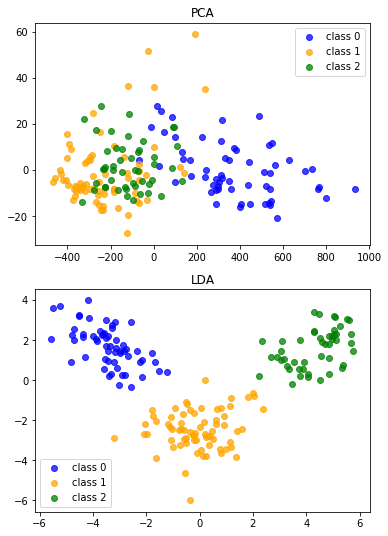

In [36]:
def plot_PCA_LDA(wine_pca, wine_lda):
    """
    Use a scatter plot to plot PCA and LDA components obtained using the functions above.
    Use a different color for each class.
    """
    plt.clf()
    fig, axes = plt.subplots(2, 1, figsize=(6, 9))
    X_RS = [wine_pca, wine_lda]
    titles = ['PCA', 'LDA']
    idxs = range(3)
    colors = ['blue', 'orange', 'green']
    labels = [f'class {i}' for i in idxs]
    for ax, X_R, title in zip(axes, X_RS, titles):
        for idx, color, label in zip(idxs, colors, labels):
            ax.scatter(X_R[y == idx, 0], X_R[y == idx, 1],
                       label=label, color=color, alpha=0.75)
        ax.set_title(title)
        ax.legend(loc='best')
    plt.show()

plot_PCA_LDA(wine_pca, wine_lda)

Which dimensionality reduction method is better? Why？[5pts]

For the wine dataset, LDA is a better dimensionality reduction method than PCA as highlighted by the clear class separation in the prior figures. Whereas PCA seeks to maximize the variance in the dataset, LDA seeks to maximize class separability given the reduced subspace. The unsupervised approach of PCA is helpful for understanding the feature composition irrespective of classification. For the wine dataset we are given the classification and it therefore makes more sense to leverage a supervised approach to not just understand the principal components in a vacuum, but rather the components which are most relevant for separating the examples into their respective classifications. By leveraging the known classifications, LDA is able to provide a more relevant component analysis.